# 2D model compare

Because our model is an implementation of the variational autoencoder, there exists a trade off between a compact representation of the cell in the low dimensional embedding space (i.e. the number of dimensions needed to describe an image $\zRef$ and $\zTarget$), a low $KL(q(z|x)|p(z)))$, and faithful reconstruction of the original image from the decoded low dimensional embedding, a high $\mathbb{E}_{q(z|x)}[\log p(x|z)]$.
The relative emphasis of one term versus the other has consequences for the model and for its applications.
For example, one might desire a less-complex data embedding to facilitate the statistical exploration and interpretation of the latent space, while in other circumstances it might be preferable for a more-complex embedding that enables the comparative analysis of high-fidelity generated images.

To demonstrate how our model performs as a function of this relationship, we adopt a modified variational objective that allows us to tune the relative weights of these two terms.

$ELBO(x) = (1-\beta) \mathbb{E}_{q(z|x)}[\log p(x|z)] - \beta KL(q(z|x)|p(z)))$

We trained 25 models of cell and nuclear shape ($\modelRef$) with $\beta$ values evenly spaced between 0 and 1 using 2D maximum-intensity-projected images of cell and nuclear shape.
Using the test data, i.e.\ data not used in the training phase, we record the average of the two terms of ELBO for each of the 25 models and plot the two as a function of $\beta$ in figure \ref{fig:3}a.
Sampling from the cell and nuclear shape representation, we show generated images across a range of $\beta$ in figure \ref{fig:3}b.
We note that compared to observed cell and nuclear shapes, generated images close to $\beta \rightarrow 0$ retain more detail and perhaps more diversity than images at $\beta \rightarrow 1$, although this comes at a trade off of increased representation dimensionality (figure \ref{fig:3_supp}).

First load each model, and get embeddings and ELBO values

In [1]:
import glob
import pickle
import json
import os
import pickle

import torch
import numpy as np
from natsort import natsorted
from tqdm import tqdm

from integrated_cell import model_utils, utils
from integrated_cell.metrics.embeddings_reference import get_latent_embeddings
from integrated_cell.models.bvae import kl_divergence


def dim_klds(mus, sigmas):
    kl_dims = list()
    for mu, sigma in zip(mus, sigmas):
        _, kl_dim, _ = kl_divergence(mu.unsqueeze(0), sigma.unsqueeze(0))
        
        kl_dims.append(kl_dim)
    
    return np.vstack(np.vstack(kl_dims))    
    
    
def get_embeddings_for_model(suffix, model_dir, parent_dir, save_path, use_current_results, mode = "validate"):

    if not os.path.exists(save_path):
        if use_current_results:
            return None
            
        networks, dp, args = utils.load_network_from_dir(model_dir, parent_dir, suffix = suffix)

        recon_loss = utils.load_losses(args)['crit_recon']

        enc = networks['enc']
        dec = networks['dec']

        enc.train(False)
        dec.train(False)

        embeddings = get_latent_embeddings(enc, dec, dp, modes=[mode], recon_loss = recon_loss, batch_size = 32)

        torch.save(embeddings, save_path)
    else:
        embeddings = torch.load(save_path)

    return embeddings


def embeddings2elbo(embeddings, alpha=0.5, mode = "validate"):

    recon_per_point = torch.mean(embeddings[mode]['ref']['recon'], 1)
    kld_per_point =  embeddings[mode]['ref']['kld']
    
    elbo_per_point = -2*((1-alpha)*recon_per_point + alpha*kld_per_point)
    
    return elbo_per_point, recon_per_point, kld_per_point


def get_embeddings_for_dir(model_dir, parent_dir, use_current_results=False, suffixes = None, mode = 'validate'):
    model_paths = np.array(natsorted(glob.glob('{}/ref_model/enc_*'.format(model_dir))))
    
    inds = np.linspace(0, len(model_paths)-1).astype('int')
    
    model_paths = model_paths[inds]
    
    if suffixes is None:
        suffixes = [model_path.split('/enc')[1].split('.pth')[0] for model_path in model_paths]
    
    results_dir = '{}/results'.format(model_dir)
    if not os.path.exists(results_dir):
        os.makedirs(results_dir)
    
    embeddings_list = list()
    
    logger_file = '{0}/ref_model/logger_tmp.pkl'.format(model_dir)
    
    if not os.path.exists(logger_file):
        return
    
    with open( logger_file, "rb" ) as fp:
        logger = pickle.load(fp)

    args_file = "{}/args.json".format(model_dir)
    with open(args_file, "r") as f:
        args = json.load(f)
    
    model_summaries = list()
    
    for suffix in suffixes:
        
        model_summary_path = "{}/ref_model/embeddings_{}{}_summary.pth".format(model_dir, mode, suffix)
        
#         if os.path.exists(model_summary_path):
#             with open(model_summary_path, "rb") as f:
#                 model_summary = pickle.load(f)
#         else:
        embeddings_path = "{}/ref_model/embeddings_{}{}.pth".format(model_dir, mode, suffix)
    
        embeddings = get_embeddings_for_model(suffix, model_dir, parent_dir, embeddings_path, use_current_results, mode = mode)

        if embeddings is None: continue

        opt = json.load(open( '{0}/args.json'.format(model_dir), "rb" ))

        iteration = int(suffix[1:])-1
        iteration_index = np.where(np.array(logger.log['iter']) == iteration)[0]

        if len(iteration_index) == 0:
            continue


        embeddings['beta'] = opt['kwargs_model']['alpha']
        embeddings['elbo'], embeddings['recon'], embeddings['kld'] = embeddings2elbo(embeddings, embeddings['beta'], mode = mode)

        klds_per_dim = dim_klds(embeddings[mode]['ref']['mu'], embeddings[mode]['ref']['sigma'])

        model_summary = {"iteration": iteration,
                "epoch": np.array(logger.log['epoch'])[iteration_index],
                "elbo": np.mean(embeddings['elbo'].numpy()),
                "recons": np.mean(embeddings['recon'].numpy()),
                "klds": np.mean(embeddings['kld'].numpy()),
                "klds_per_dim": np.mean(klds_per_dim, 0),
                "model_dir": model_dir,
                "label": model_dir.split('/')[-2],
                "suffix": suffix,
                "args": args}

        with open(model_summary_path, "wb") as f:
            pickle.dump(model_summary, f)

        model_summaries.append(model_summary)
            
    return model_summaries


gpu_ids = [5]
os.environ["CUDA_VISIBLE_DEVICES"] = ",".join([str(ID) for ID in gpu_ids])
if len(gpu_ids) == 1:
    torch.backends.cudnn.enabled = True
    torch.backends.cudnn.benchmark = True


parent_dir = "/allen/aics/modeling/gregj/results/integrated_cell/"

model_parent = '{}/test_cbvae_beta_ref'.format(parent_dir)

model_dirs = glob.glob('/allen/aics/modeling/gregj/results/integrated_cell/test_cbvae_beta_ref/job_*/')

        
save_dir = '{}/results'.format(model_parent)
if not os.path.exists(save_dir):
    os.makedirs(save_dir)
    
results_dir = save_dir
    
    

data_list = list()
for i, model_dir in enumerate(model_dirs):
    print(model_dir)
    
    # do model selection based on validation data
    model_summaries = get_embeddings_for_dir(model_dir, parent_dir, use_current_results = False, mode='validate')

    if model_summaries is None:
        continue
        
    # find the best model    
    elbo = np.array([model_summary['elbo'] for model_summary in model_summaries])
    suffix = [model_summary['suffix'] for model_summary in model_summaries] 
    
    if len(elbo) == 0:
        continue
    
    max_ind = np.argmax(elbo)
    best_elbo = elbo[max_ind]
    best_suffix = suffix[max_ind]
    
    best_ind = int(max_ind)
    
    # get results for test data
    model_summaries = get_embeddings_for_dir(model_dir, parent_dir, use_current_results = False, mode = "test", suffixes=[best_suffix])
    
    iteration = np.array([model_summary['iteration'] for model_summary in model_summaries])
    epoch = np.array([model_summary['epoch'] for model_summary in model_summaries])
    elbo = np.array([model_summary['elbo'] for model_summary in model_summaries])
    recons = np.array([model_summary['recons'] for model_summary in model_summaries])
    klds = np.array([model_summary['klds'] for model_summary in model_summaries])
    args = [model_summary['args'] for model_summary in model_summaries]
    suffix = [model_summary['suffix'] for model_summary in model_summaries]    
    klds_per_dim = np.hstack([model_summary['klds_per_dim'] for model_summary in model_summaries])
    
    beta = args[0]['kwargs_model']['alpha']
    
    label = model_dir.split('/')[-2]
    
    model_summary = {"iteration": iteration,
                    "epoch": epoch,
                    "elbo": elbo,
                    "recons": recons,
                    "klds": klds,
                    "klds_per_dim": klds_per_dim,
                    "model_dir": model_dir,
                    "label": label,
                    "suffix": suffix,
                    "args": args,
                    "best_elbo": best_elbo,
                    "beta": beta}
    

    data_list.append(model_summary)
        




/allen/aics/modeling/gregj/results/integrated_cell/test_cbvae_beta_ref/job_313/
/allen/aics/modeling/gregj/results/integrated_cell/test_cbvae_beta_ref/job_303/
/allen/aics/modeling/gregj/results/integrated_cell/test_cbvae_beta_ref/job_378/
/allen/aics/modeling/gregj/results/integrated_cell/test_cbvae_beta_ref/job_306/
/allen/aics/modeling/gregj/results/integrated_cell/test_cbvae_beta_ref/job_331/
/allen/aics/modeling/gregj/results/integrated_cell/test_cbvae_beta_ref/job_329/
/allen/aics/modeling/gregj/results/integrated_cell/test_cbvae_beta_ref/job_298/
/allen/aics/modeling/gregj/results/integrated_cell/test_cbvae_beta_ref/job_317/
/allen/aics/modeling/gregj/results/integrated_cell/test_cbvae_beta_ref/job_341/
/allen/aics/modeling/gregj/results/integrated_cell/test_cbvae_beta_ref/job_343/
/allen/aics/modeling/gregj/results/integrated_cell/test_cbvae_beta_ref/job_332/
/allen/aics/modeling/gregj/results/integrated_cell/test_cbvae_beta_ref/job_302/
/allen/aics/modeling/gregj/results/integ

In [2]:
# Reorganize the data structure into something slightly more manageable 

import tqdm 
import matplotlib

import torch

from skimage.external.tifffile import imsave

ks = list(range(1,11))

cuda = True

# dims = 2048
# block_idx = InceptionV3.BLOCK_INDEX_BY_DIM[dims]
# model = InceptionV3([block_idx])
# if cuda:
#     model.cuda()

#inception score stuff
# inception_dir = '{}/results/inception/'.format(model_parent)

#Sample a generated and real images into their own class folders
modes = ['train','test','validate']

im_paths_real = {}
im_scores_real = {}
im_paths_gen = {}

class_list = list()
path_list = list()
mode_list = list()

_, dp, _ = utils.load_network_from_dir(data_list[0]['model_dir'], parent_dir)
dp.image_parent = '/allen/aics/modeling/gregj/results/ipp/scp_19_04_10/'

class_list = np.array(class_list)
path_list = np.array(path_list)
mode_list = np.array(mode_list)

class_list_gen = class_list[mode_list == 'validate']

im_paths_gen = {}
im_scores_gen = {}

#sample n_train images and stick them into directories
for i, data in enumerate(data_list):    

    model_ind = 0
    
    if len(data['suffix']) == 0:
        continue
        
    #Make sure we get the hightest-ELBO model
        
    suffix = data['suffix'][model_ind]
    model_dir = data['model_dir']
    model_short = data['model_dir'].split('/')[-2]

    im_paths_gen[i] = {}
    im_scores_gen[i] = {}
    
    im_scores_gen[i]['model_dir'] = data['model_dir']
    im_scores_gen[i]['label'] = data['label']
    im_scores_gen[i]['suffix'] = data['suffix'][model_ind]    
    im_scores_gen[i]['elbo'] = data['elbo'][model_ind]
    im_scores_gen[i]['recon'] = data['recons'][model_ind]
    im_scores_gen[i]['kld'] = data['klds'][model_ind]
    im_scores_gen[i]['klds_per_dim'] = data['klds_per_dim'][model_ind]    
    im_scores_gen[i]['epoch'] = data['epoch'][model_ind]
    im_scores_gen[i]['im_path'] = '{}/ref_model/progress_{}.png'.format(model_dir, int(data['elbo'][model_ind]))
    im_scores_gen[i]['args'] = data['args'][model_ind]
    im_scores_gen[i]['beta'] = data['beta']
    
  

/allen/aics/modeling/rorydm/projects/pytorch_integrated_cell/integrated_cell/utils/utils.py:75: UserWarning: args file exists and overwrite is not set to True. Using existing args file.
  "args file exists and overwrite is not set to True. Using existing args file."


loading from /allen/aics/modeling/gregj/results/integrated_cell/test_cbvae_beta_ref//job_313/ref_model/enc.pth
loading from /allen/aics/modeling/gregj/results/integrated_cell/test_cbvae_beta_ref//job_313/ref_model/dec.pth


/allen/aics/apps/hpc_shared/mod/anaconda3-5.3.0/envs/pytorch_integrated_cell/lib/python3.7/site-packages/ipykernel_launcher.py:41: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison


In [3]:
import pandas as pd

for i in im_scores_gen:
    #log specific model architechure choices
    
    color = 'k'
    
    if im_scores_gen[i]['args']['dataProvider'] == 'RefDataProvider':
        im_scores_gen[i]['intensity_norm'] = 0
    elif im_scores_gen[i]['args']['dataProvider'] == 'RescaledIntensityRefDataProvider':
        im_scores_gen[i]['intensity_norm'] = 1
    else:
        raise error
        
    if im_scores_gen[i]['args']['dataProvider'] == 'RescaledIntensityRefDataProvider':
        marker = 'p'
    else:
        marker = '^'
        
#     im_scores_gen[i]['beta'] = im_scores_gen[i]['args']['kwargs_model']['beta']
    im_scores_gen[i]['marker'] = marker
    im_scores_gen[i]['color'] = color



for i in im_scores_gen:
    beta = im_scores_gen[i]['beta']
    im_scores_gen[i]['model_arch_str'] = rf"$ \beta $ = {beta}"
    
df_master = pd.DataFrame.from_dict([im_scores_gen[i] for i in im_scores_gen])    
df_master = df_master.sort_values('beta')


# for s in df_master['model_arch_str']: print(s)

## Plot models as a function of $\beta$

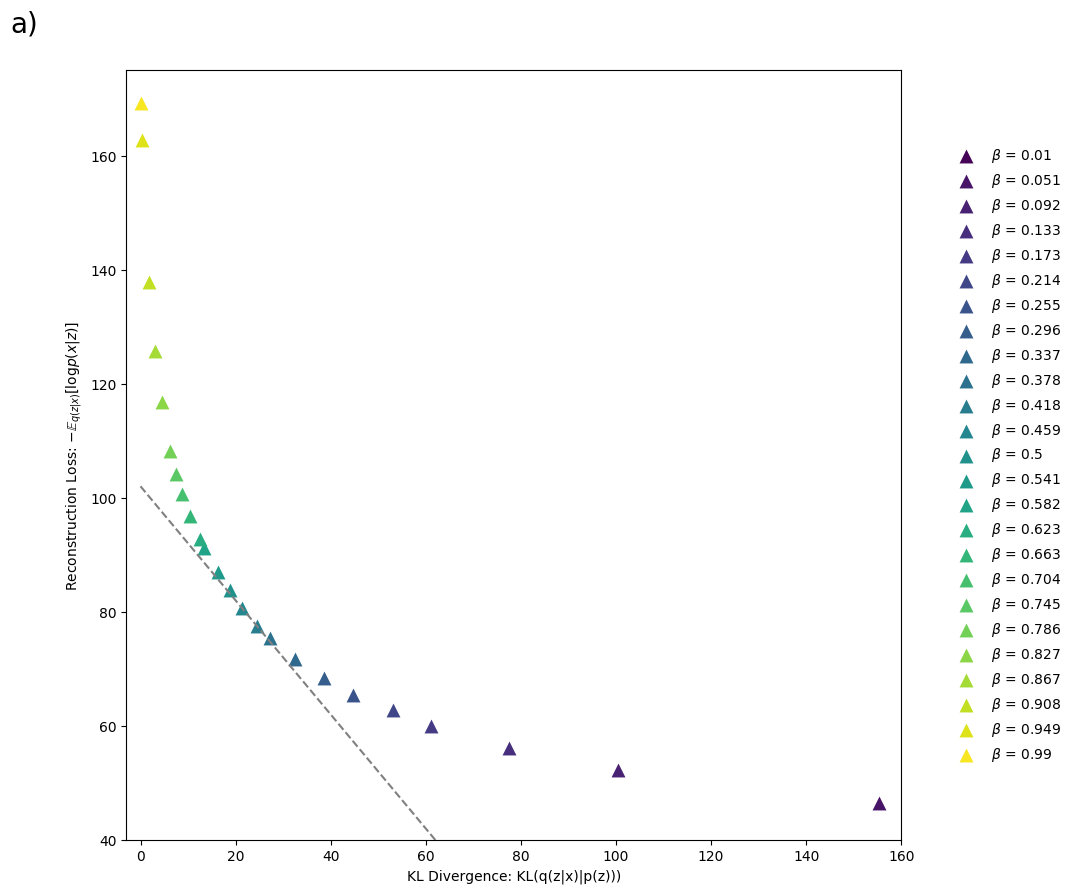

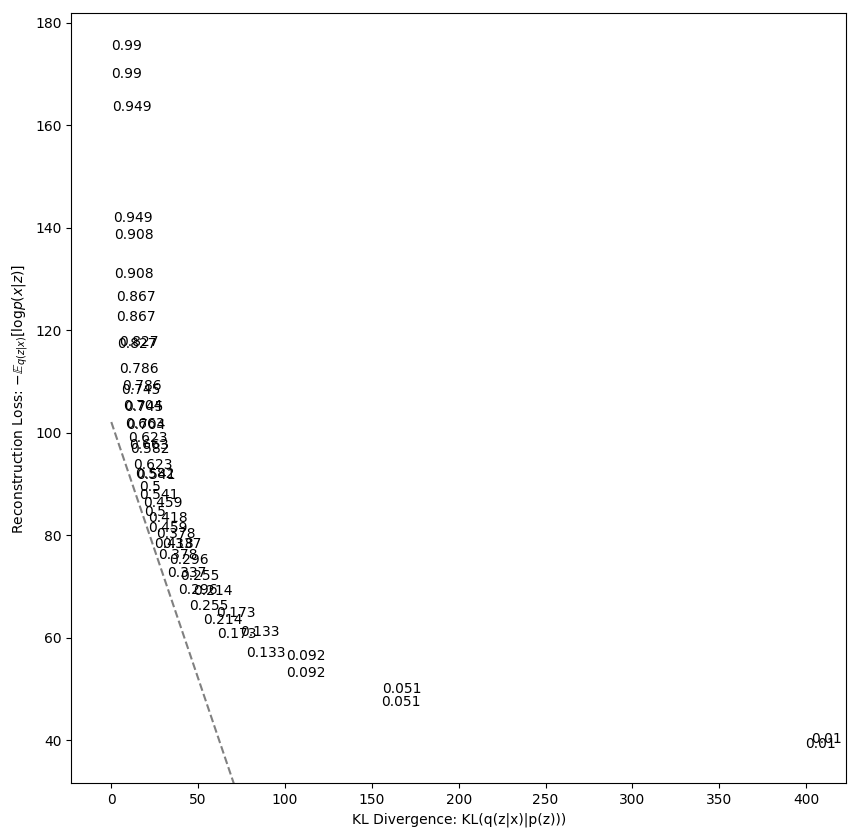

In [4]:
import matplotlib.pyplot as plt
from matplotlib import cm

%matplotlib inline

plt.style.use('default')

letter_x = -0.15
letter_y = 1.05

# df = df_master[(df_master['beta'] == 1) & (df_master['masked_channels'] == -1)]

df = df_master 
# markers = ['^', 's', 'p', 'h', '*', '$G$']*2
# colors = [[0, 0, 0]]*6 + [[1, 0, 0]]*6

colors = np.arange(df.shape[0])

colors = cm.viridis(df['beta'])

plt.figure(figsize=[10,10])
# plt.subplot(2,2,1)

for i, [r, d, label, marker, color, beta] in enumerate(zip(df['kld'], df['recon'], df['model_arch_str'], df['marker'], colors, df['beta'])):
    if marker == 'p': 
        label = None
        continue
        
    ax = plt.scatter(r, d, label=label, marker = marker, color = color, linewidth=0, s = 100)
    
elbo = np.min(df['recon']+df['kld'])
plt.plot([0, elbo], [elbo, 0], '--', c='gray')

plt.xlabel(r'KL Divergence: KL(q(z|x)|p(z)))')
plt.ylabel(r'Reconstruction Loss: $- \mathbb{E}_{q(z|x)}[\log p(x|z)]$')   

# plt.colorbar(ax)
plt.legend(bbox_to_anchor=(1.05, 0.5), loc='center left', ncol=1, frameon=False)

plt.ylim([40, 175])
plt.xlim([-3, 160])

plt.gca().text(letter_x, letter_y, 'a)', transform=plt.gca().transAxes, size=20)

# plt.axis('equal')    
plt.show()
plt.close()

plt.style.use('default')

letter_x = -0.15
letter_y = 1.05

df = df_master

plt.figure(figsize=[10,10])

for i, [r, d, label, marker, color, beta] in enumerate(zip(df['kld'], df['recon'], df['model_arch_str'], df['marker'], df['color'], df['beta'])):
    
    plt.scatter(r, d, label=label, marker = '$'+str(beta)+'$', color = 'w', linewidth=0, s = 100)
    plt.text(r, d, str(beta))
    
xlim = plt.xlim()
ylim = plt.ylim()    
    
elbo = np.min(df['recon']+df['kld'])
plt.plot([0, elbo], [elbo, 0], '--', c='gray')

plt.xlim(xlim)
plt.ylim(ylim)
    
plt.xlabel('KL Divergence: KL(q(z|x)|p(z)))')
plt.ylabel(r'Reconstruction Loss: $- \mathbb{E}_{q(z|x)}[\log p(x|z)]$')    

plt.savefig('{}/model_selection_beta.png'.format(save_dir), bbox_inches='tight', dpi=90)

plt.show()
plt.close()

## Plot models as a function of $\beta$ but prettier this time

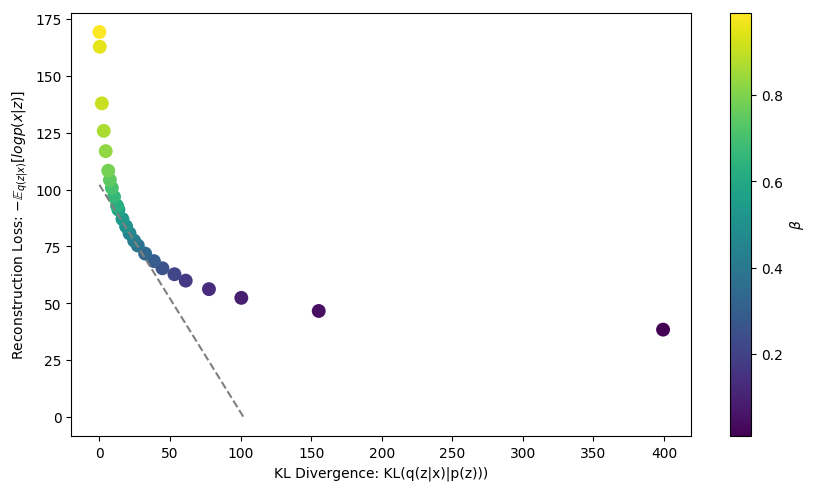

In [30]:
import matplotlib.pyplot as plt
from matplotlib import cm

%matplotlib inline

plt.style.use('default')

letter_x = -0.15
letter_y = 1.05

# df = df_master[(df_master['beta'] == 1) & (df_master['masked_channels'] == -1)]

df = df_master.iloc[np.array(df_master['intensity_norm'] == 0)] 
# markers = ['^', 's', 'p', 'h', '*', '$G$']*2
# colors = [[0, 0, 0]]*6 + [[1, 0, 0]]*6

colors = np.arange(df.shape[0])

colors = cm.viridis(df['beta'])

plt.figure(figsize=[10,5.5])
# plt.subplot(2,2,1)

# for i, [r, d, label, marker, color, beta] in enumerate(zip(df['kld'], df['recon'], df['model_arch_str'], df['marker'], colors, df['beta'])):
#     if marker == 'p': 
#         label = None
#         continue
        
ax = plt.scatter(df['kld'], df['recon'], c = df['beta'], linewidth=0, s = 100, cmap='viridis')
    
elbo = np.min(df['recon']+df['kld'])
plt.plot([0, elbo], [elbo, 0], '--', c='gray')

plt.xlabel('KL Divergence: KL(q(z|x)|p(z)))')
plt.ylabel(r'Reconstruction Loss: $- \mathbb{E}_{q(z|x)}[logp(x|z)]$')   

cb = plt.colorbar(ax, aspect=20, orientation="vertical", pad=0.05)
cb.set_label(rf'$ \beta $')
# plt.legend(bbox_to_anchor=(1.05, 0.5), loc='center left', ncol=1, frameon=False)

plt.axis('equal')
plt.axis('tight')

# plt.ylim([-3, 175])
# plt.xlim([-3, 420])

# plt.gca().text(letter_x, letter_y, 'a)', transform=plt.gca().transAxes, size=20)

# plt.axis('equal')    

plt.savefig('{}/model_selection_beta_clean.png'.format(results_dir), bbox_inches='tight', dpi=300)

plt.show()
plt.close()

In [6]:
results_dir

'/allen/aics/modeling/gregj/results/integrated_cell//test_cbvae_beta_ref/results'

## Print out the best-on-validation set models for each $\beta$

In [7]:
best_model = 'asdfasdfasdf'

for i, data in enumerate(data_list):
    if data['model_dir'] == "/allen/aics/modeling/gregj/results/integrated_cell/test_cbvae/2019-07-19-09:27:15/":
        best_model = i
        break

best_model = np.argmax(best_elbo)

for data in data_list:
# data = data_list[best_model]


    ind = 0
    save_dir = data['model_dir']

    print("model_dir = '{}'".format(data['model_dir']))
    print("parent_dir = '{}'".format(parent_dir))
    print("suffix = '{}'".format(data['suffix'][ind]))

model_dir = '/allen/aics/modeling/gregj/results/integrated_cell/test_cbvae_beta_ref/job_313/'
parent_dir = '/allen/aics/modeling/gregj/results/integrated_cell/'
suffix = '_46028'
model_dir = '/allen/aics/modeling/gregj/results/integrated_cell/test_cbvae_beta_ref/job_303/'
parent_dir = '/allen/aics/modeling/gregj/results/integrated_cell/'
suffix = '_60956'
model_dir = '/allen/aics/modeling/gregj/results/integrated_cell/test_cbvae_beta_ref/job_378/'
parent_dir = '/allen/aics/modeling/gregj/results/integrated_cell/'
suffix = '_106984'
model_dir = '/allen/aics/modeling/gregj/results/integrated_cell/test_cbvae_beta_ref/job_306/'
parent_dir = '/allen/aics/modeling/gregj/results/integrated_cell/'
suffix = '_38564'
model_dir = '/allen/aics/modeling/gregj/results/integrated_cell/test_cbvae_beta_ref/job_331/'
parent_dir = '/allen/aics/modeling/gregj/results/integrated_cell/'
suffix = '_77128'
model_dir = '/allen/aics/modeling/gregj/results/integrated_cell/test_cbvae_beta_ref/job_329/'
parent_dir

## Do feature calculation for some subset of models

In [8]:
import tqdm
import pickle
import pandas as pd
import scipy.stats


import importlib as imp
import integrated_cell.utils.features
imp.reload(integrated_cell.utils)
imp.reload(integrated_cell.utils.features)

from integrated_cell.utils.features import im2feats
from aicsfeature.extractor.common import get_shape_features, get_intensity_features, get_skeleton_features

def save_feats(im, save_path):
    
    assert im.shape[0] == 1 
    
    im_tmp = im[0].cpu().numpy()

    im_tmp = np.expand_dims(im_tmp, 3)

    im_struct = np.copy(im_tmp)
    
    for i in range(im_struct.shape[0]):
        im_struct[i] = (im_struct[i] / np.max(im_struct[i]))*255
        
    im_struct = im_struct.astype('uint8')
    
    feats = {}
    
    feats['dna_shape'] = get_shape_features(seg=im_struct[1]>0)
    feats['dna_inten'] = get_intensity_features(img=im_struct[1])
    feats['dna_skeleton'] = get_skeleton_features(seg=im_struct[1])

    feats['cell_shape'] = get_shape_features(seg=im_struct[0]>0)
    feats['cell_inten'] = get_intensity_features(img=im_struct[0])
    feats['cell_skeleton'] = get_skeleton_features(seg=im_struct[0])
#     feats = im2feats(im_struct[0], im_struct[1], im_struct, extra_features=["io_intensity", "bright_spots", "intensity", "skeleton"])
    
    with open(save_path, "wb") as f:
        pickle.dump(feats, f)
    
    return


def load_feats(save_paths):
    feats = list()
    for save_path in save_paths:
        with open(save_path, 'rb') as f:
            feat_tmp = pickle.load(f)
            
        feat = {}
        for i in feat_tmp:
            for j in feat_tmp[i]:
                feat["{}_{}".format(i,j)] = feat_tmp[i][j]            
            
        feats.append(feat)

    feats = pd.DataFrame.from_dict(feats)
        
    return feats

In [ ]:
from tqdm import tqdm

feats_parent_dir = "{}/feats/".format(results_dir)

all_feats_save_path = "{}/all_feats.pkl".format(feats_parent_dir)

intensity_norms = np.unique(df_master['intensity_norm'])

feature_path_dict = {}
#there are 2 normalization methods
for intensity_norm in intensity_norms:
    
    #get the dataframe for this normalization method
    df_norm = df_master[df_master['intensity_norm'] == intensity_norm]
    
    #get the parent directory for saving this normalization method    
    save_norm_parent = "{}/norm_{}".format(feats_parent_dir, intensity_norm)
    if not os.path.exists(save_norm_parent):
        os.makedirs(save_norm_parent)
        
    save_norm_feats = "{}/feats_test".format(save_norm_parent)
    if not os.path.exists(save_norm_feats):
        os.makedirs(save_norm_feats)
        
    #get a data provider for this normalization methods
    networks, dp, args = utils.load_network_from_dir(df_norm['model_dir'].iloc[0], parent_dir, suffix=df_norm['suffix'].iloc[0])
    
    enc = networks['enc'].cuda()
    
    x = dp.get_sample()
    
    z_tmp = enc(x.cuda())[0]
    z_tmp = z_tmp[[0]]
    n_latent = z_tmp.shape[1]
    n_dat = dp.get_n_dat('test')
    

    
    save_real_feats_paths = ['{}/feat_{}.pkl'.format(save_norm_feats, i) for i in range(n_dat)]
    
    #loop through all images and save them
    for i, save_real_feat_path in tqdm(enumerate(save_real_feats_paths)):
        if not os.path.exists(save_real_feat_path):
            im = dp.get_sample('test', [i])   
            save_feats(im, save_real_feat_path)

    feature_path_dict[intensity_norm] = {}
    feature_path_dict[intensity_norm]['real'] = load_feats(save_real_feats_paths)
    feature_path_dict[intensity_norm]['gen'] = {}
    
    # now loop through all the models under this normalization method, saving generated images and features
    for i in range(df_norm.shape[0]):
        
        save_feats_dir = '{}/{}'.format(save_norm_parent, df_master['label'].iloc[i])
        
        if not os.path.exists(save_feats_dir):
            os.makedirs(save_feats_dir)
        
        #load the network
        network_loaded = False
        
        dec = networks['dec'].cuda()
        
        save_gen_feats_paths = ['{}/feat_{}.pkl'.format(save_feats_dir, i) for i in range(n_dat)]
        
        for j, save_path in tqdm(enumerate(save_gen_feats_paths)):
            
            if not os.path.exists(save_path):

                if not network_loaded:
                    networks, dp, args = utils.load_network_from_dir(df_norm['model_dir'].iloc[i], parent_dir, suffix=df_norm['suffix'].iloc[i])
                    network_loaded = True

                with torch.no_grad():
                    im = dec(z_tmp.normal_())      

                save_feats(im, save_path)

        beta = df_norm['beta'].iloc[i]
        feature_path_dict[intensity_norm]['gen'][beta] = load_feats(save_gen_feats_paths)
        
        
with open(all_feats_save_path, "wb") as f:
    pickle.dump(feature_path_dict, f)      

loading from /allen/aics/modeling/gregj/results/integrated_cell/test_cbvae_beta_ref//job_298/ref_model/enc_53492.pth
loading from /allen/aics/modeling/gregj/results/integrated_cell/test_cbvae_beta_ref//job_298/ref_model/dec_53492.pth


4745it [00:25, 184.25it/s]
4745it [00:24, 190.40it/s]
4745it [00:25, 189.77it/s]
4745it [00:24, 189.84it/s]
4745it [00:26, 178.65it/s]
4745it [00:26, 178.04it/s]
4745it [00:27, 173.14it/s]
4745it [00:27, 175.65it/s]
4745it [00:27, 172.38it/s]
4745it [00:26, 176.12it/s]
4745it [00:25, 183.54it/s]
4745it [00:26, 179.10it/s]
4745it [00:26, 177.44it/s]
4745it [00:26, 179.10it/s]
4745it [00:26, 179.03it/s]
4745it [00:26, 175.77it/s]
4745it [00:26, 182.27it/s]
4745it [00:27, 174.18it/s]
4745it [00:26, 181.04it/s]
4745it [00:27, 173.73it/s]
4745it [00:25, 187.38it/s]
4100it [00:21, 183.50it/s]

In [ ]:
feature_path_dict[intensity_norm]['real'].columns

## Print precision/recall manifold stats across betas 

In [19]:
from integrated_cell.metrics.precision_recall import precision_recall

# colors = cm.Paired(np.arange(len(prs))/len(prs))

k = 3

n = len(feature_path_dict[intensity_norm]['gen'])
colors = cm.Paired(np.arange(n)/n)

for intensity_norm in intensity_norms:
    
    f1 = torch.Tensor(feature_path_dict[intensity_norm]['real'].values)

    keep_cols = ~torch.all(f1[0] == f1, 0) * ~torch.all(np.isnan(f1)==1, 0)
    
#     print(keep_cols)
#     print(feature_path_dict[intensity_norm]['real'].columns[keep_cols])
    
    f1 = f1[:,keep_cols] 
    
    keep_rows = ~torch.any(np.isnan(f1)== 1, 1)
    f1 = f1[keep_rows]
    
    mu = torch.mean(f1, 0)
    std = torch.std(f1, 0)

    f1 = (f1 - mu) / std

    prs = {}
    for beta in feature_path_dict[intensity_norm]['gen']:
        f2 = torch.Tensor(feature_path_dict[intensity_norm]['gen'][beta].values)
        f2 = f2[:,keep_cols]
        
        keep_rows = ~torch.any(np.isnan(f2)== 1, 1)
        f2 = f2[keep_rows]
        
        f2 = (f2 - mu) / std

        prs[beta] = precision_recall(f1, f2, k = [k])



    betas = [beta for beta in prs]
    precisions = [prs[beta][k]['precision'] for beta in prs]
    recalls = [prs[beta][k]['recall'] for beta in prs]


    plt.figure()
    plt.title('intensity normalization = {}'.format(intensity_norm))
    plt.plot(betas, precisions, label = 'precision')
    plt.plot(betas, recalls, label = 'recall')
    plt.legend()
    
    plt.xlabel('beta')
    plt.ylabel('{}-NN Manifold precision & recall'.format(k))    


KeyError: 'normalized'

## Print example images for each beta
Rows from top to bottom are:  
training input  
training output  
test input  
test output  
sampled images  

In [ ]:
import PIL.Image
import imageio

for intensity_norm in intensity_norms:
    df_tmp = df_master[df_master['intensity_norm'] == intensity_norm]
    df_tmp = df_tmp.iloc[np.argsort(df_tmp['beta'])]
    
    for i in range(df_tmp.shape[0]):
        
        im_out_path = '{}/ref_model/progress_{}.png'.format(df_tmp.iloc[i]['model_dir'], int(df_tmp.iloc[i]['epoch'][0]))
    
        print('Beta: {}, Intensity Norm: {}'.format(df_tmp.iloc[i]['beta'], intensity_norm))
    
        im_progress = imageio.imread(im_out_path)
        display(PIL.Image.fromarray(im_progress))
        
        
    

## Print off real versus generated feature distributions

In [ ]:
with open(all_feats_save_path, "rb") as f:
    feature_dict = pickle.load(f)  

In [ ]:
all_feats_save_path = '/allen/aics/modeling/gregj/results/integrated_cell//test_cbvae_beta_ref/results/feats//all_feats.pkl'

intensity_norms = ['unnormalized', 'normalized']

with open(all_feats_save_path, "rb") as f:
    feature_dict = pickle.load(f) 

for i, intensity_norm in enumerate(intensity_norms):
    
    #features for a specified intensity norm
    feature_dict[i]
    
    #each sub-dict has real and gen features
    real_feats = feature_dict[i]['real']
    
    feature_dict[i]['gen']
    
    #then gen feature dict has features for many betas
    betas = [k for k in feature_dict[i]['gen']]
    
#     print(betas[0])
    
    features_for_the_first_beta = feature_dict[i]['gen'][betas[0]]
    
#     print(features_for_the_first_beta)
    
    #the real columns and the generated columns (for each beta) are the same
    for columnReal, columnGen in zip(real_feats.columns, features_for_the_first_beta):
        assert columnReal == columnGen
    


In [ ]:
from sklearn import preprocessing
from scipy.stats import gaussian_kde
from matplotlib import cm
from matplotlib.lines import Line2D

intensity_norm_meth = 0

features = feature_dict[intensity_norm_meth]

cols_to_plot = [
    "cell_shape_volume",
    "cell_shape_surface_area",
    'cell_inten_intensity_mean',    
    "dna_shape_volume",
#     "dna_shape_surface_area",
    'dna_inten_intensity_std'


#     'cell_inten_intensity_median',
#     'cell_inten_intensity_std',
#     'dna_inten_intensity_mean',
#     'dna_inten_intensity_median',
    
]

n_feats = len(cols_to_plot)
n_betas_to_plot = 5
color_real = 'r'
colors_betas = cm.viridis(np.linspace(0, 1, n_betas_to_plot))

betas = np.array([k for k in features['gen']])

betas_to_plot = betas[np.linspace(0, len(betas)-1, n_betas_to_plot).astype(int)]

print(betas_to_plot)

points_to_eval_kde = np.linspace(-3,10,100)

plt.figure(figsize=[10, 6])

for i, col in enumerate(cols_to_plot):
    plt.subplot(2, 3, i+1)
    plt.title(col.replace('_', ' ').replace('surface area', 'perimeter').replace('volume', 'area').replace(' inten ', ' ').replace('dna ', 'DNA '))
    
    feats_real = features['real'][col].values.reshape(-1,1)
    
    scalar = preprocessing.StandardScaler()
    scalar.fit(feats_real)

    feats_real = scalar.transform(feats_real).flatten()
    
    density_real = gaussian_kde(feats_real).evaluate(points_to_eval_kde)

    plt.plot(points_to_eval_kde, density_real, label='observed (z-scored)', color = color_real, zorder=1E10)
    plt.fill_between(points_to_eval_kde, density_real, alpha = 0.1, color = color_real, zorder=1E10)
    
    if i == 0:
        plt.ylabel('relative distribution')
    
    for j, beta_to_plot in enumerate(betas_to_plot):
        feats_gen = features['gen'][beta_to_plot][col].values.reshape(-1,1)
        
        feats_gen = scalar.transform(feats_gen).flatten()
        density = gaussian_kde(feats_gen).evaluate(points_to_eval_kde)
        
        plt.plot(points_to_eval_kde, density, label=rf'$ \beta $ = {beta_to_plot}', color = colors_betas[j])
        plt.fill_between(points_to_eval_kde, density, alpha = 0.1, color = colors_betas[j])


    plt.yticks([])
        
#     if i == (len(cols_to_plot) - 1):
#         plt.legend(bbox_to_anchor=(1.05, .95), frameon=False)
    
plt.subplot(2, 3, i+2)    

legend_elements = [Line2D([0], [0], color=color_real, lw=4, label='observed (z-scored)')] + [Line2D([0], [0], color=colors_betas[j], lw=4, label=rf'$ \beta $ = {beta_to_plot}') for j, beta_to_plot in  enumerate(betas_to_plot)]
plt.gca().legend(handles=legend_elements, loc='center', frameon=False)
plt.axis('off')
    
plt.tight_layout()

plt.savefig('{}/features_and_betas.png'.format(results_dir), bbox_inches='tight', dpi=90)
plt.show()

plt.close()

## Print off generated images for the models at different $\beta$

In [ ]:
import scipy.misc
from integrated_cell.utils.plots import tensor2im

df = df_master.iloc[np.array(df_master['intensity_norm'] == 0)] 

gen_dir = f"{results_dir}/gen"
if not os.path.exists(gen_dir):
    os.makedirs(gen_dir)

n_imgs_to_gen = 10    
    
im_dict = {}
    
for i in tqdm(range(df.shape[0])):
    row = df.iloc[i]
    
    beta = row['beta']
    label = row['label']
    
    gen_img_dir = f"{gen_dir}/{label}"
    if not os.path.exists(gen_img_dir):
        os.makedirs(gen_img_dir)
#     else:
#         continue
    
    networks, dp, args = utils.load_network_from_dir(row['model_dir'], parent_dir, suffix = row['suffix'])
    
    sample = torch.zeros([n_imgs_to_gen, args['kwargs_dec']['n_latent_dim']]).normal_().cuda()
    dec = networks['dec'].cuda()
    
    x_gen = dec.forward(sample)
    
    im_dict[beta] = {}
    for j in range(n_imgs_to_gen):
        im = tensor2im(x_gen[[j]])
        
        im_dict[beta][j] = im
        scipy.misc.imsave(f'{gen_dir}/im_{j}.png', im)


[0.01  0.173 0.337 0.5   0.663 0.827 0.99 ]


/allen/aics/apps/hpc_shared/mod/anaconda3-5.3.0/envs/pytorch_integrated_cell/lib/python3.7/site-packages/ipykernel_launcher.py:18: DeprecationWarning: `imsave` is deprecated!
`imsave` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imwrite`` instead.


(-0.5, 671.5, 479.5, -0.5)

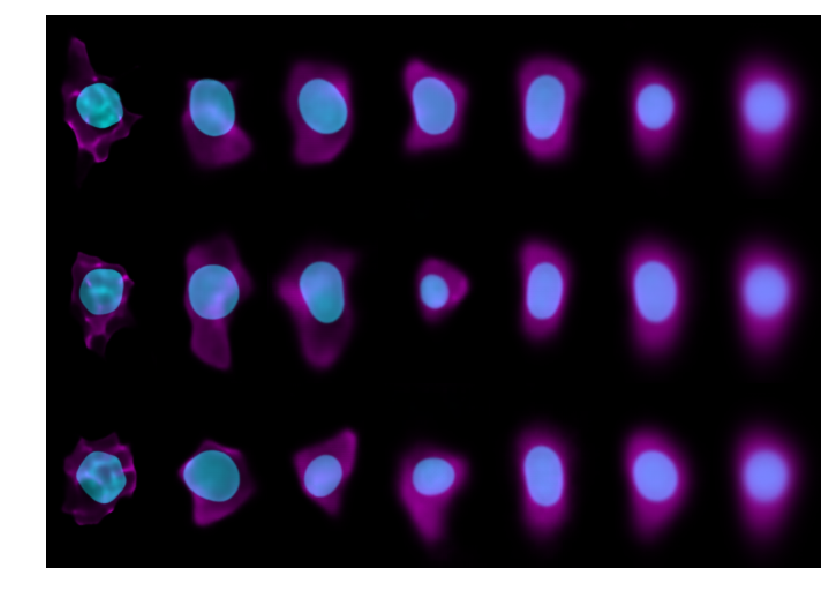

In [35]:
n_imgs_per_beta = 3
n_betas_to_plot = 7

betas_to_plot = betas[np.linspace(0, len(betas)-1, n_betas_to_plot).astype(int)]

print(betas_to_plot)

beta_cols = list()
for beta in betas_to_plot:
    beta_col = list()
    for i in range(n_imgs_per_beta):
        beta_col.append(im_dict[beta][i])
        
    beta_cols.append(np.vstack(beta_col))
    
im_out = np.hstack(beta_cols)

scipy.misc.imsave(f'{results_dir}/im_generated.png', im_out)

plt.figure(figsize=[10,10])
plt.imshow(im_out)
plt.axis('off')

# plt.savefig(f'{results_dir}/im_generated.png', bbox_inches='tight', dpi=300)


/allen/aics/apps/hpc_shared/mod/anaconda3-5.3.0/envs/pytorch_integrated_cell/lib/python3.7/site-packages/ipykernel_launcher.py:9: DeprecationWarning: `imsave` is deprecated!
`imsave` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imwrite`` instead.
  if __name__ == '__main__':


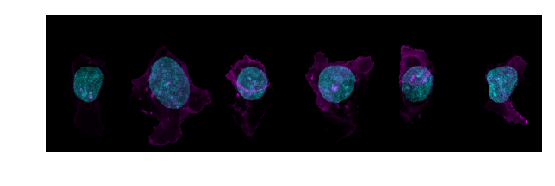

/allen/aics/apps/hpc_shared/mod/anaconda3-5.3.0/envs/pytorch_integrated_cell/lib/python3.7/site-packages/ipykernel_launcher.py:15: DeprecationWarning: `imsave` is deprecated!
`imsave` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imwrite`` instead.
  from ipykernel import kernelapp as app


In [34]:
n_sampled_to_plot = n_betas_to_plot - 1

ims = dp.get_sample('test', list(range(n_sampled_to_plot)))



im_real = np.hstack([tensor2im(ims[[i]]/torch.max(ims[[i]])) for i in range(n_sampled_to_plot)])

scipy.misc.imsave(f'{results_dir}/im_sampled.png', im_real)

plt.imshow(im_real)
plt.axis('off')
plt.show()

scipy.misc.imsave(f'{results_dir}/im_sampled.png', im_real)
# plt.savefig(f'{results_dir}/im_sampled.png', bbox_inches='tight', dpi=300)

plt.close()


In [29]:
results_dir

'/allen/aics/modeling/gregj/results/integrated_cell//test_cbvae_beta_ref/results'